# TP classification de sons à rendre

Tom Bevan (tom.bevan@etu.unice.fr)
Vinh Faucher (vinh.faucher@etu.unice.fr)

Polytech SI3 - SSII - 2021-22

# Données



In [49]:
#les imports nécessaires pour la suite
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.datasets import fetch_lfw_people
import cv2
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.metrics import classification_report

## Les données
On va utiliser le jeu de données "lfw_people" en filtrant les classes contenant minimum 100 images.

In [30]:
"""On récupère les personnes ayant au minimum 100 photos dans la base de données et sans modification de taille"""
lfw = fetch_lfw_people(min_faces_per_person=100, resize=1)
taille_mfcc = 13
X = lfw.images
y = lfw.target
"""On crée nos bases d'entrainement et de test"""
Xtrain, Xtest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=33)

# On crée les sifts

In [60]:
def build_sifts_from_image_list(images, siftsRes, sifts_per_image=[]):

    """
    Remplit le numpy array sifts passé en paramètres avec les SIFTs de toutes les images ainsi que le tableau contenant
    le nombre de sifts de chaque image.

    Arguments:
         images: une liste d'images, dont on souhaite calculer les SIFTs.
         siftsRes: le numpy array à remplir
         sifts_per_image: le tableau auquel on ajoute le nombre de SIFTs de chaque image.
    """

    for image in images:
        gray_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(gray_image, None)
        #print(siftsRes.shape)
        #print(des)
        siftsRes = np.append(siftsRes, des, axis=0)
        sifts_per_image.append(len(des))

    return siftsRes


sifts = np.empty(shape = (0, 128))
sifts_per_image = []

#On crée nos sifts à partir de notre base d'entrainement
sifts = build_sifts_from_image_list(Xtrain, sifts, sifts_per_image)
#print(sifts.shape)

## Partitionnement en K-means

In [61]:
def build_clusters_list(sifts, k = 500):

    """
    Partitionne les SIFTs en k clusters et retourne le cluster auquel appartient chaque SIFT.

    Arguments:
        sifts: le numpy array de SIFTs à partitionner.
        k: le nombre de clusters souhaité.
    """

    kMeans = MiniBatchKMeans(n_clusters = k)
    kMeans.fit(sifts)
    return kMeans.labels_


def build_images_bows(labels, sifts_per_image, k = 500):

    """
    Construit un numpy array contenant les BOWs de chaque image.

    Arguments:
        labels: les labels de chaque SIFTs, CAD à quel cluster appartient chaque SIFT.
        sifts_per_image: le tableau décrivant le nombre de SIFT dans chaque image.
        k: le nombre de clusters.
    """

    all_bows = np.zeros(shape = (len(sifts_per_image), k))

    parcours = 0
    parcours_bis = 0
    for sift_amount in sifts_per_image:
        bow = np.zeros(k)
        for i in range(parcours + sift_amount):
            bow[labels[i]] += 1/sift_amount
        parcours += sift_amount
        all_bows[parcours_bis] = bow
        parcours_bis += 1

    return all_bows

In [62]:
"""Création des clusters"""

labels = build_clusters_list(sifts)

In [63]:
"""Construction des BOWs"""

bows = build_images_bows(labels, sifts_per_image)

In [64]:
"""print(labels)
print(bows.shape)
print(bows[0])
print(sum(bows[0]))"""

[113 306  72 ... 467 162  72]
(855, 500)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01886792
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01886792 0.         0.01886792
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01886792
 0.         0.         0.         0.01886792 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01886792 0.         0.01886792 0.
 0.         0.         0.         0.         0.         0.
 0.01886792 0.         0.         0.01886792 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.01886792 0.         0.         0.01886792 0.
 0.01886792 0.         0.         0.         0.   

### Classification

In [65]:
"""Régression logistique puis classification"""

logisticRegr = LogisticRegression(max_iter = 100000)

scaler = preprocessing.StandardScaler().fit(bows)
xtrain = scaler.transform(bows)
logisticRegr.fit(xtrain, yTrain)

LogisticRegression(max_iter=100000)

In [66]:
"""On essaie de prédire l'efficacité de notre apprentissage """
ypred = logisticRegr.predict(xtrain)
print("train F1 score = ", f1_score(yTrain, ypred, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTrain, ypred))


train F1 score =  0.5064327485380117
train accuracy score =  0.5064327485380117


On peut voir que les scores ne sont pas très élevés, ce qui veut dire que notre apprentissage n'est pas suffisament bon pour reconnaitre de façon efficace les photos.

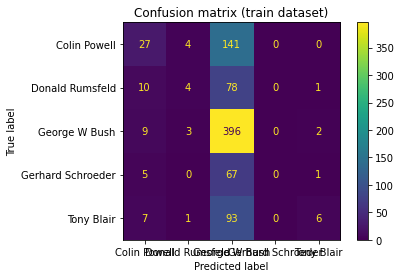

In [67]:
"""Maintenant on s'occupe de la matrice de confusion"""
cm = confusion_matrix(yTrain, ypred, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lfw.target_names)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')
plt.show()

On peut voir que dans le cas de George W Bush, notre code est relativement efficace, mais confond quand même en grande partie avec d'autres personnes. Quand à la reconnaissance des autres personnes, on voit que les scores sont extrêmement bas, ce qui veut dire que la classification linéaire n'est pas efficace dans notre cas et qu'on doit s'y prendre autrement.

### On compare avec notre base de test

In [68]:
"""On reprend les mêmes étapes que précédemment mais pour notre base de test"""
sifts_test = np.empty(shape = (0, 128))
sifts_per_image_test = []

sifts_test = build_sifts_from_image_list(Xtest, sifts_test, sifts_per_image_test)

labels_test = build_clusters_list(sifts_test)

bows_test = build_images_bows(labels_test, sifts_per_image_test)




In [69]:
scaler = preprocessing.StandardScaler().fit(bows_test)
xtest = scaler.transform(bows_test)

ypred_test = logisticRegr.predict(xtest)
print("train F1 score = ", f1_score(yTest, ypred_test, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTest, ypred_test))


train F1 score =  0.3263157894736842
train accuracy score =  0.3263157894736842


On peut voir que le score est extrêmement bas, on peut donc s'attendre à un grand nombre d'erreur dans la reconnaissance des photos.

In [ ]:
cm = confusion_matrix(yTest, ypred_test, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lfw.target_names)
disp.plot()
disp.ax_.set_title('Confusion matrix (test dataset)')
plt.show()

La matrice de confusion de la base de test est cohérente avec les résultats obtenus précédemment et montre que notre code n'est pas très efficace dans la reconnaissance d'images.

### Classification SVC

In [57]:
classif = svm.SVC(kernel='linear', decision_function_shape='ovr', C=100)
classif.fit(bows, yTrain)
#print('support vectors: ', classif.support_vectors_)

print(f'Accuracy - ={classif.score(bows, yTrain):.3f}')

Accuracy - =0.566


prediction class [0 0 0 0 0 0 0 0 0 0 4 4 0 0 4 4 4 4 4 4 4 4 0 4 4 4 4 4 0 0 0 0 4 0 4 4 4
 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 0 3 2 4 0 0 0 4 2 2 0 0 0 2 2 0 0 0 0 0 2 3 4 2 2 2 2 2 2
 2 2 2 2 3 2 2 3 3 2 3 3 2 3 4 2 3 3 2 2 2 1 2 0 2 2 2 3 2 2 2 2 2 1 1 2 0
 2 2 3 2 3 2 3 0 3 3 1 0 2 1 0 1 3 1 1 1 1 1 1 1 1 1 1 4 1 1 3 1 1 3 1 3 1
 1 3 1 1 1 4 1 1 1 1 1 1 1 1 3 1 3 1 1 1 1 1 1 3 1 3 1 3 1 3 3 3 3 1 3 1 3
 3 0 3 3 3 3 3 3 0 3 3 1 3 3 1 3 3 3 0 3 3 3 3 3 3 3 3 3 3 1 3 1 1 3 3 0 3
 1 3 3 3 3 1 3 3 3 3 1 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3]
support vectors:  [[1.11111111e-02 1.11111111e-02 2.22222222e-02 ... 0.00000000e+00
  2.22222222e-02 2.22222222e-02]
 [3.92156863e-02 2.94117647e-02 6.86274510e-02 ... 4.90196078e-02
  6.86274510e-02 2.94117647e-02]
 [5.55555556e-02 4.16666667e-02 9.72222222e-02 ... 6.94444444e-02
  2.08333333e-01 6.94444444e-02]
 ...
 [6.76344086e+00 6.64516129e+00 7.06451613e+00 ... 5.49462366e+00
  1.02580645e+01 4

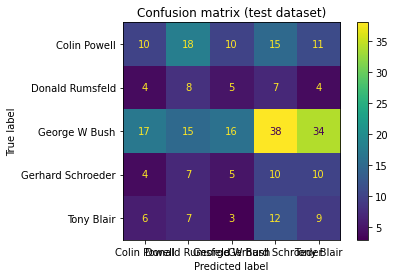

In [58]:
print('prediction class', classif.predict(xtest))
print('support vectors: ', classif.support_vectors_)

cm = confusion_matrix(yTest, classif.predict(xtest), labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lfw.target_names)
disp.plot()
disp.ax_.set_title('Confusion matrix (test dataset)')
plt.show()

In [59]:
print(classification_report(yTest, classif.predict(xtest), zero_division=0))

              precision    recall  f1-score   support

           0       0.24      0.16      0.19        64
           1       0.15      0.29      0.19        28
           2       0.41      0.13      0.20       120
           3       0.12      0.28      0.17        36
           4       0.13      0.24      0.17        37

    accuracy                           0.19       285
   macro avg       0.21      0.22      0.19       285
weighted avg       0.27      0.19      0.19       285



Accuracy - =0.487


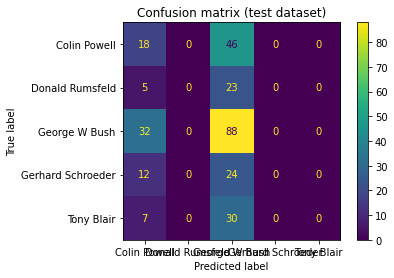

              precision    recall  f1-score   support

           0       0.24      0.28      0.26        64
           1       0.00      0.00      0.00        28
           2       0.42      0.73      0.53       120
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00        37

    accuracy                           0.37       285
   macro avg       0.13      0.20      0.16       285
weighted avg       0.23      0.37      0.28       285



In [84]:
classif = svm.SVC(kernel='rbf', decision_function_shape='ovr', C=100)
classif.fit(bows, yTrain)

print(f'Accuracy - ={classif.score(bows, yTrain):.3f}')

cm = confusion_matrix(yTest, classif.predict(xtest), labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lfw.target_names)
disp.plot()
disp.ax_.set_title('Confusion matrix (test dataset)')
plt.show()

print(classification_report(yTest, classif.predict(xtest), zero_division=0))

Accuracy - =0.515


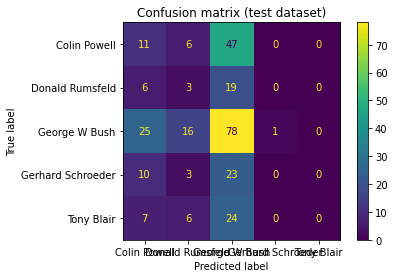

              precision    recall  f1-score   support

           0       0.19      0.17      0.18        64
           1       0.09      0.11      0.10        28
           2       0.41      0.65      0.50       120
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00        37

    accuracy                           0.32       285
   macro avg       0.14      0.19      0.16       285
weighted avg       0.22      0.32      0.26       285



In [76]:
classif = svm.SVC(kernel='poly', decision_function_shape='ovr', C=100)
classif.fit(bows, yTrain)

print(f'Accuracy - ={classif.score(bows, yTrain):.3f}')

cm = confusion_matrix(yTest, classif.predict(xtest), labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lfw.target_names)
disp.plot()
disp.ax_.set_title('Confusion matrix (test dataset)')
plt.show()

print(classification_report(yTest, classif.predict(xtest), zero_division=0))